In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")


In [62]:

# Load the dataset
data = pd.read_csv('train.csv') 

# Convert 'Date' column to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d/%m/%Y')

# group by month
#data['Date'] = data['Order Date'].dt.to_period('M')
#preprocessed_data = data.groupby(['Date', 'Category'], as_index=False)['Sales'].sum()
#preprocessed_data = preprocessed_data[['Date', 'Category', 'Sales']]


# group by day
preprocessed_data = data.groupby(['Order Date', 'Category'], as_index=False)['Sales'].sum()

preprocessed_data = preprocessed_data[['Order Date', 'Category', 'Sales']]

# Display preprocessed data
#print(preprocessed_data.head())

# List of unique categories



In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from pandas.tseries.offsets import DateOffset

def moving_average(category, test_size=0.2):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]
    train_data, test_data = train_test_split(category_data, test_size=test_size, shuffle=False)

    forecast_values_train = train_data['Sales'].rolling(window=5).mean()
    forecast_values = forecast_values_train.reindex(category_data.index).ffill()

    plt.figure(figsize=(12, 8))
    plt.scatter(train_data['Order Date'], train_data['Sales'], label=f"Training Sales ('{category}')", color='black')
    plt.scatter(test_data['Order Date'], test_data['Sales'], label=f"Test Sales ('{category}')", color='gray')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Moving Average ('{category}')", color='blue')
    plt.legend()
    plt.title(f'Moving Average Forecasting for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(test_data['Sales'], forecast_values.loc[test_data.index])
    mae = mean_absolute_error(test_data['Sales'], forecast_values.loc[test_data.index])
    mape = mean_absolute_percentage_error(test_data['Sales'], forecast_values.loc[test_data.index])
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    return mse, mae, mape

def exponential_smoothing(category, test_size=0.2):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]
    train_data, test_data = train_test_split(category_data, test_size=test_size, shuffle=False)

    model = SimpleExpSmoothing(train_data['Sales']).fit(smoothing_level=0.2, optimized=False)
    forecast_values = model.predict(start=test_data.index[0], end=test_data.index[-1])

    all_dates = pd.concat([train_data['Order Date'], test_data['Order Date']])
    all_values = pd.concat([model.fittedvalues, forecast_values])

    plt.figure(figsize=(12, 8))
    plt.scatter(train_data['Order Date'], train_data['Sales'], label=f"Training Sales ('{category}')", color='black')
    plt.scatter(test_data['Order Date'], test_data['Sales'], label=f"Test Sales ('{category}')", color='gray')
    plt.plot(all_dates, all_values, label=f"Exponential Smoothing ('{category}')", color='red')
    plt.legend()
    plt.title(f'Exponential Smoothing Forecasting for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(test_data['Sales'], forecast_values)
    mae = mean_absolute_error(test_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(test_data['Sales'], forecast_values)
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    return mse, mae, mape

def linear_regression(category, test_size=0.2):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]
    train_data, test_data = train_test_split(category_data, test_size=test_size, shuffle=False)

    X_train = train_data['Order Date'].astype('int64').values.reshape(-1, 1)
    y_train = train_data['Sales']
    model = LinearRegression().fit(X_train, y_train)

    X_test = test_data['Order Date'].astype('int64').values.reshape(-1, 1)
    forecast_values = model.predict(X_test)

    plt.figure(figsize=(12, 8))
    plt.scatter(train_data['Order Date'], train_data['Sales'], label=f"Training Sales ('{category}')", color='black')
    plt.scatter(test_data['Order Date'], test_data['Sales'], label=f"Test Sales ('{category}')", color='gray')
    plt.plot(test_data['Order Date'], forecast_values, label=f"Linear Regression ('{category}')", color='yellow')
    plt.legend()
    plt.title(f'Linear Regression Forecasting for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(test_data['Sales'], forecast_values)
    mae = mean_absolute_error(test_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(test_data['Sales'], forecast_values)
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    return mse, mae, mape

def deseasonalized_linear_regression(category, test_size=0.2):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]
    train_data, test_data = train_test_split(category_data, test_size=test_size, shuffle=False)

    train_data['Day'] = train_data['Order Date'].dt.day
    daily_means = train_data.groupby('Day')['Sales'].mean()

    full_seasonal_pattern = train_data['Day'].map(daily_means)
    deseasonalized = train_data['Sales'] / full_seasonal_pattern

    days_since_start = (train_data['Order Date'] - train_data['Order Date'].min()).dt.days
    X_train = days_since_start.values.reshape(-1, 1)
    y_train = deseasonalized.values
    model = LinearRegression().fit(X_train, y_train)

    forecast_dates = pd.date_range(start=test_data['Order Date'].min(), periods=len(test_data), freq='D')
    forecast_days_since_start = (forecast_dates - train_data['Order Date'].min()).days
    forecast_values = model.predict(forecast_days_since_start.values.reshape(-1, 1))

    # Correcting the line that caused the error
    forecast_days = pd.Series(forecast_dates.day)
    mapped_means = forecast_days.map(daily_means).fillna(method='ffill')
    forecasted_sales = forecast_values * mapped_means.values

    plt.figure(figsize=(12, 8))
    plt.scatter(train_data['Order Date'], train_data['Sales'], label=f"Training Sales ('{category}')", color='black')
    plt.scatter(test_data['Order Date'], test_data['Sales'], label=f"Test Sales ('{category}')", color='gray')
    plt.plot(forecast_dates, forecasted_sales, label="Deseasonalized Linear Regression Forecast", color='green')
    plt.legend()
    plt.title(f'Deseasonalized Linear Regression Forecasting for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(test_data['Sales'], forecasted_sales[:len(test_data)])
    mae = mean_absolute_error(test_data['Sales'], forecasted_sales[:len(test_data)])
    mape = mean_absolute_percentage_error(test_data['Sales'], forecasted_sales[:len(test_data)])
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    return mse, mae, mape

def holts_method(category, test_size=0.2):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]
    train_data, test_data = train_test_split(category_data, test_size=test_size, shuffle=False)

    model = ExponentialSmoothing(train_data['Sales'], trend='add').fit()
    forecast_values = model.forecast(len(test_data))

    plt.figure(figsize=(12, 8))
    plt.scatter(train_data['Order Date'], train_data['Sales'], label=f"Training Sales ('{category}')", color='black')
    plt.scatter(test_data['Order Date'], test_data['Sales'], label=f"Test Sales ('{category}')", color='gray')
    plt.plot(train_data['Order Date'].append(test_data['Order Date']), model.fittedvalues.append(forecast_values), label=f"Holt's Method ('{category}')", color='orange')
    plt.legend()
    plt.title(f"Holt's Method Forecasting for {category}")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(test_data['Sales'], forecast_values)
    mae = mean_absolute_error(test_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(test_data['Sales'], forecast_values)
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    return mse, mae, mape

def winters_method(category, test_size=0.2):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]
    train_data, test_data = train_test_split(category_data, test_size=test_size, shuffle=False)

    model = ExponentialSmoothing(train_data['Sales'], trend='add', seasonal='add', seasonal_periods=30).fit()
    forecast_values = model.forecast(len(test_data))

    plt.figure(figsize=(12, 8))
    plt.scatter(train_data['Order Date'], train_data['Sales'], label=f"Training Sales ('{category}')", color='black')
    plt.scatter(test_data['Order Date'], test_data['Sales'], label=f"Test Sales ('{category}')", color='gray')
    plt.plot(train_data['Order Date'].append(test_data['Order Date']), model.fittedvalues.append(forecast_values), label=f"Winter's Method ('{category}')", color='green')
    plt.legend()
    plt.title(f"Winter's Method Forecasting for {category}")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(test_data['Sales'], forecast_values)
    mae = mean_absolute_error(test_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(test_data['Sales'], forecast_values)
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    return mse, mae, mape

Category: Office Supplies


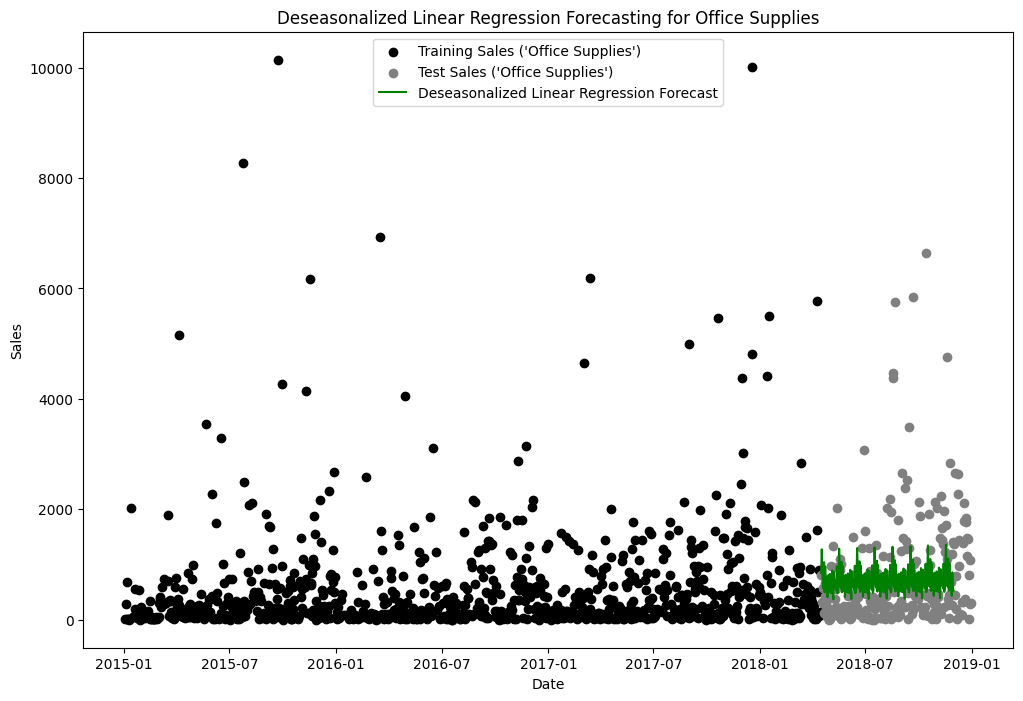

MSE: 1060398.717940602, MAE: 663.9774218015172, MAPE: 6.995813306597389
Category: Furniture


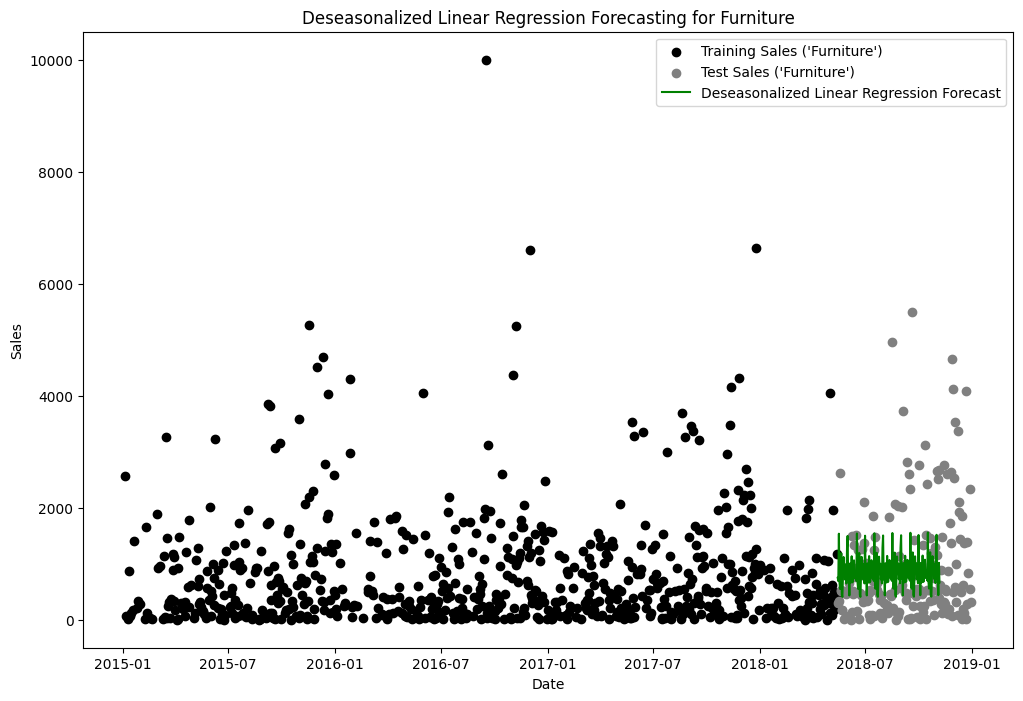

MSE: 1231974.3763565442, MAE: 796.3968241122232, MAPE: 7.839006516850862
Category: Technology


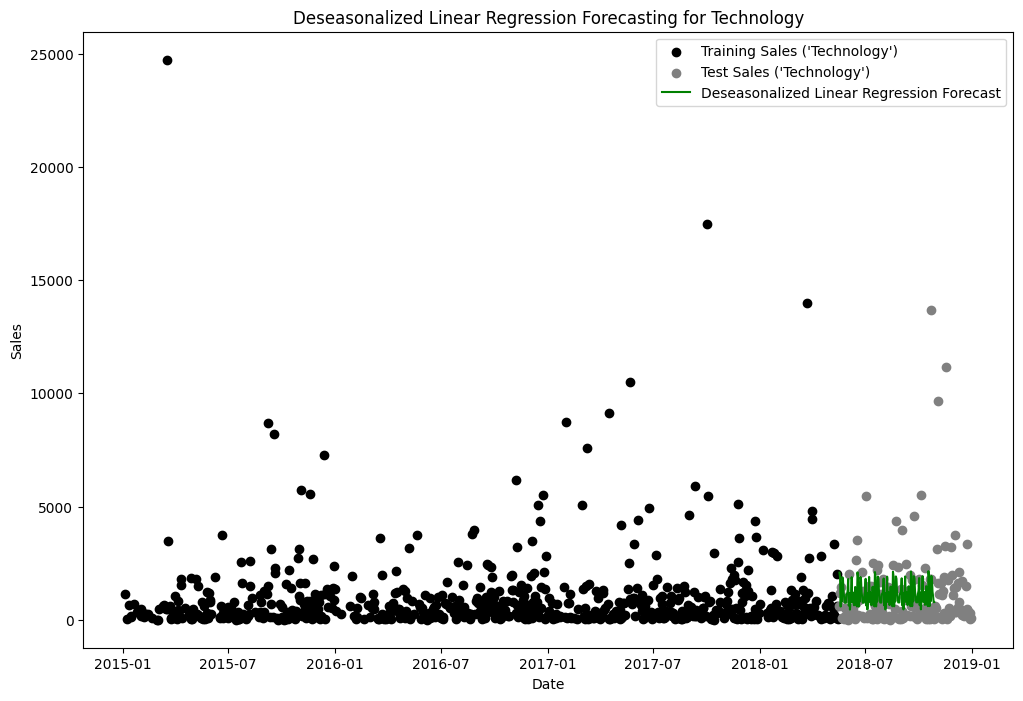

MSE: 3276954.8640892776, MAE: 1086.2031468753694, MAPE: 11.814470307050303


,Category,Method,MSE,MAE,MAPE
0,Office Supplies,Deseasonalized Linear Regression,1.060399e+06,663.977422,6.995813
1,Furniture,Deseasonalized Linear Regression,1.231974e+06,796.396824,7.839007
2,Technology,Deseasonalized Linear Regression,3.276955e+06,1086.203147,11.814470


In [64]:
categories = preprocessed_data['Category'].unique()
methods = {
    #'Moving Average': moving_average,
    #'Exponential Smoothing': exponential_smoothing,
    #'Linear Regression': linear_regression,
    'Deseasonalized Linear Regression': deseasonalized_linear_regression,
    #"Holt's Method": holts_method,
    #"Winter's Method": winters_method
}

performance_metrics = []

for category in categories:
    print(f'Category: {category}')
    for method_name, method_func in methods.items():
        mse, mae, mape = method_func(category)
        performance_metrics.append({
            'Category': category,
            'Method': method_name,
            'MSE': mse,
            'MAE': mae,
            'MAPE': mape
        })

performance_metrics = pd.DataFrame(performance_metrics)
performance_metrics